## Project Assignment, Winter Call, A.Y. 2022/2023 - Audio Intent Detection

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.io.wavfile import read
from scipy.stats import zscore

from librosa.effects import time_stretch, preemphasis, trim
from librosa.display import specshow
from librosa.feature import mfcc
from librosa import resample

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC


seed = 42
np.random.seed(seed)

### 1. Data exploration

In [2]:
# -- LOADING THE DATASET --
df = pd.read_csv("./dsl_data/development.csv")
sample_rate = 16000 # only 300 recordings have been sampled at 22050 Hz instead of 16 KHz

audios = []
for path in df["path"]:
    sr, audio = read(path)
    audio = audio.astype('float32')
    if sr != sample_rate:
        audio = resample(audio, orig_sr=sr, target_sr=sample_rate)
    audios.append(audio)

df['audio'] = audios
df['label'] = df['action'] + df['object']

df.drop(labels=['path', 'action', 'object'], axis='columns', inplace=True)
display(df.head())

,Id,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,audio,label
0,0,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",change languagenone
1,1,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",activatemusic
2,2,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",deactivatelights
3,3,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume
4,4,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume


The base dataset contains the paths to the audio recordings and a series of informations about the speakers. Let us have a look on the data distributions of these features

#----------------- NUMBER OF SPEAKERS -----------------#
87

#----------------- NULL VALUES COUNTS -----------------#
Id                                       0
speakerId                                0
Self-reported fluency level              0
First Language spoken                    0
Current language used for work/school    0
gender                                   0
ageRange                                 0
audio                                    0
label                                    0
dtype: int64

#----------------- DATA DISTRIBUTIONS -----------------#


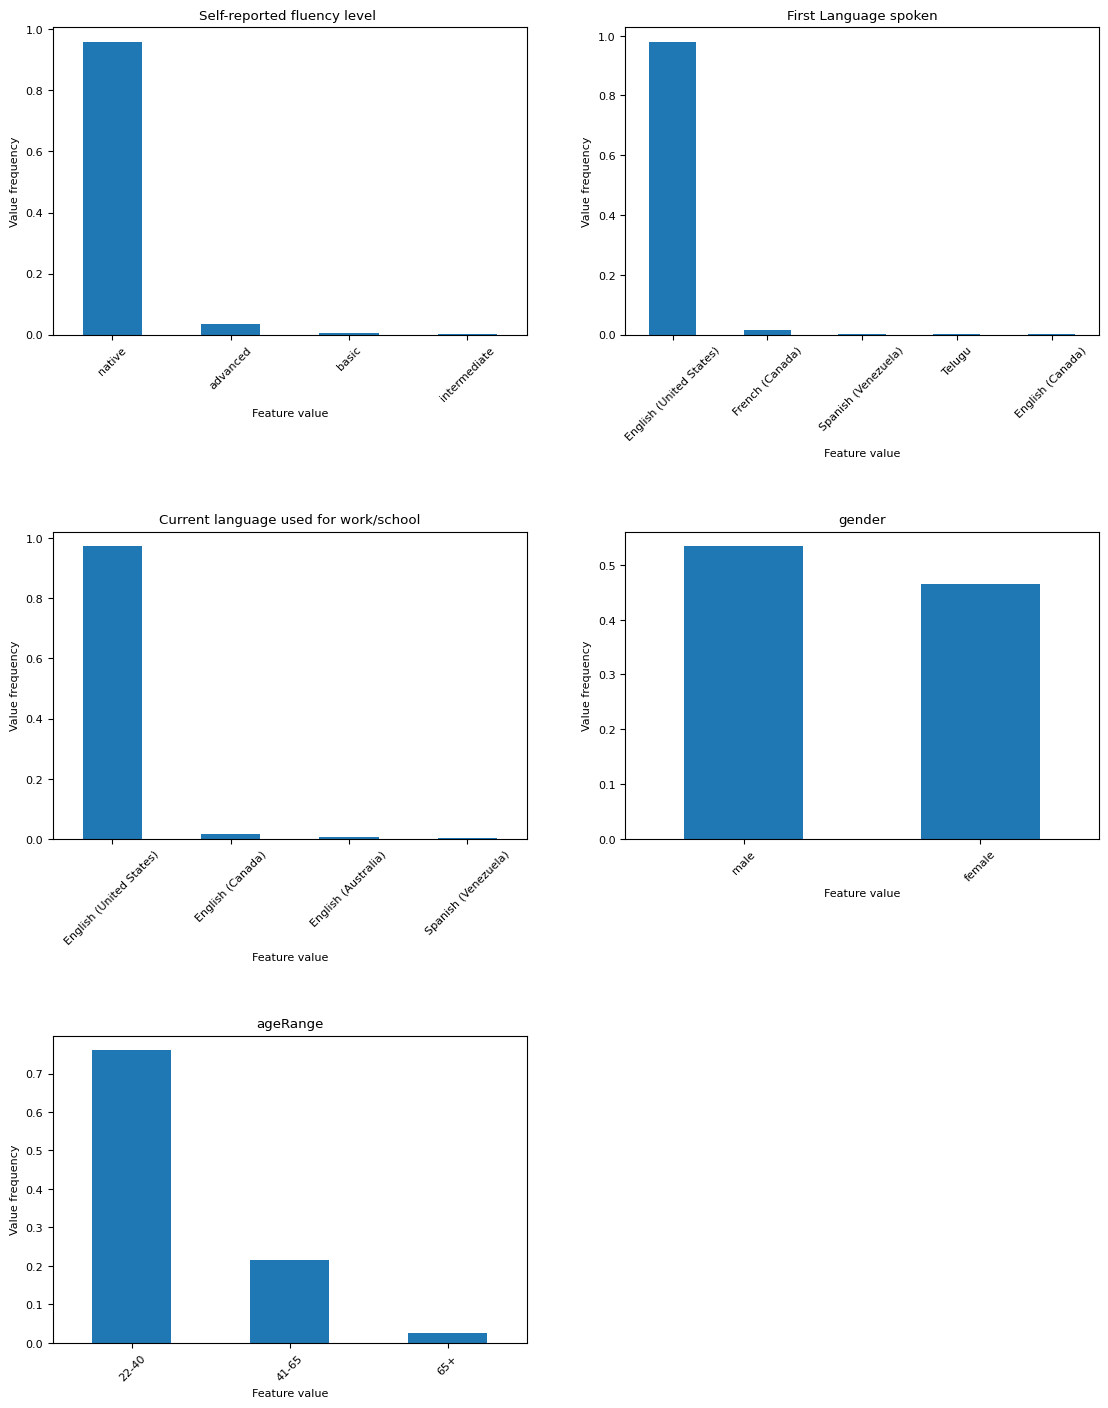

In [3]:
# -- PRINTING THE NUMBER OF SPEAKERS -- #
print("#----------------- NUMBER OF SPEAKERS -----------------#")
print(df['speakerId'].unique().size)

# -- PRINTING THE NUMBER OF MISSING VALUES FOR EACH FEATURE --
print("\n#----------------- NULL VALUES COUNTS -----------------#")
print(df.isna().sum())

# -- PLOTTING THE COMPOSITION OF THE FEATURES --
print("\n#----------------- DATA DISTRIBUTIONS -----------------#")

plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(3,2,figsize=(12,15))
for i, feature in enumerate(df.columns[2:7]):
    ax[i//2, i%2].title.set_size(10)
    ax[i//2, i%2].set_xlabel('Feature value')
    ax[i//2, i%2].set_ylabel('Value frequency')
    df[feature].value_counts(normalize=True).plot(title=feature, kind='bar', ax=ax[i//2, i%2], rot=45)
fig.delaxes(ax[2][1])
fig.tight_layout(pad=5.0)
plt.show()

We can notice how the majority of the samples assume the same values for most of the features (their data distributions are heavily unbalanced); the exceptions to this trend may be considered as outliers, but they could also be important in order to train the classifier for a wider range of possible inputs and to make it more general. Thus, we have decided to keep them.

The distribution of the 'speakerId' has not been plotted because of its huge cardinality: the resulting graph would be hardly understandable.

There are no missing values in the whole dataframe.

#----------------- RECORDINGS LENGTHS DISTRIBUTION -----------------#
count    9854.000000
mean        2.639782
std         3.133639
min         0.650188
25%         1.706687
50%         2.043375
75%         2.414875
max        20.000000
dtype: float64


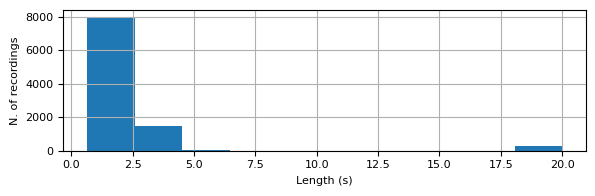


#--------------- SAMPLE RECORDING TIME DOMAIN WAVE PLOT ---------------#


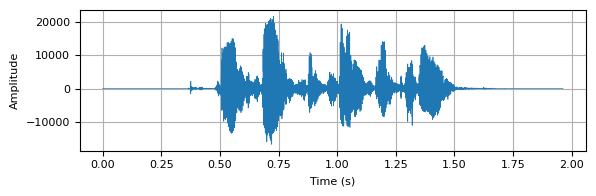

In [4]:
# -- AUDIO RECORDINGS EXPLORATION --

# length
audios_lenghts = np.array([audio.size/sample_rate for audio in df['audio']]) # audio lengths in seconds
print("#----------------- RECORDINGS LENGTHS DISTRIBUTION -----------------#")
print(pd.Series(audios_lenghts).describe())
fig, ax = plt.subplots(figsize=(6,2))
ax.hist(audios_lenghts)
ax.set_xlabel("Length (s)")
ax.set_ylabel("N. of recordings")
ax.grid(True)
fig.tight_layout()
plt.show()

# time domain wave plot
idx = np.random.randint(0, df.shape[0])
recording = df.loc[idx, 'audio']
length = audios_lenghts[idx]

print("\n#--------------- SAMPLE RECORDING TIME DOMAIN WAVE PLOT ---------------#")
fig, ax = plt.subplots(figsize=(6,2))
ax.plot(np.arange(0, length, 1/sample_rate), recording, linewidth=0.5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.grid(True)
fig.tight_layout()
plt.show()

The recordings can contain silence both before or after the utterance. Most of them is characterized by a length between 0.6 and 5 seconds, but there are some outliers too (the maximum length is 20 seconds).

<AxesSubplot: title={'center': 'Training Labels - relative frequencies'}, xlabel='Label frequency', ylabel='Label'>

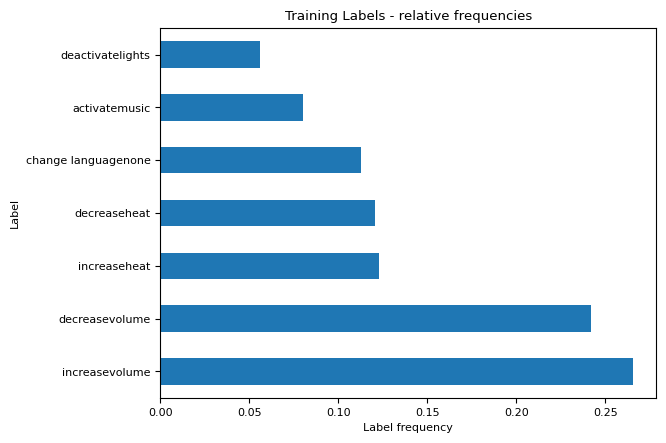

In [5]:
# -- LABELS EXPLORATION --
df['label'].value_counts(normalize=True).plot(title='Training Labels - relative frequencies', kind='barh', xlabel='Label frequency', ylabel='Label')

We can clearly see how the distribution of the classes in the development set is unbalanced.

### 2. Data preprocessing

Our strategy consists in the computation of the mfccs of the recordings, which are often used for audio classification tasks. Since the number of extracted coefficients depends on the length of the recording, we need to modify the duration of the audios in order to make them consistent.

The preliminary steps that preceed the computation of the mfccs are then the trimming (which is used to remove the regions of silence from the recordings), the stretching (which modifies the length of the recordings) and the pre-emphasis (which should improve the SNR of the recordings).

In [6]:
def extract_features_from_audio(audios, length):
    trimmed = [trim(y=audio, top_db=20)[0] for audio in audios] # removing the regions of silence
    stretched = [time_stretch(y=audio, rate=(audio.size)/length) for audio in trimmed] # adjusting the recording lengths
    emphasized = [preemphasis(y=audio) for audio in stretched]

    X = np.array([mfcc(y=audio, sr=sample_rate, n_mfcc=25, n_fft=375, n_mels=40, hop_length=175).flatten() for audio in emphasized]) # extracting the mfccs of the recordings
    
    return X, trimmed, stretched, emphasized

# -- AUDIO FEATURE EXTRACTION --
desired_duration = 2.6 # seconds
length = sample_rate * desired_duration

X_audio, trimmed_audios, stretched_audios, emphasized_audios = extract_features_from_audio(df['audio'], length)

#----------------- RECORDINGS LENGTHS DISTRIBUTION AFTER TRIMMING -----------------#
count    9854.000000
mean        1.078171
std         0.457773
min         0.192000
50%         0.992000
99%         2.639040
max        10.400000
dtype: float64

#--------------- EFFECT OF THE PRE PROCESSING ON THE SAMPLE RECORDING ---------------#


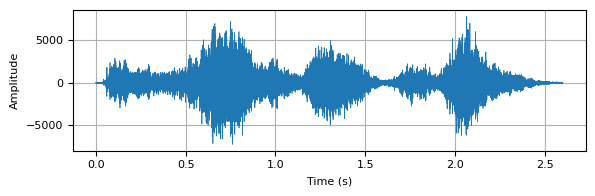


#--------------- CEPSTRUM OF THE SAMPLE RECORDING ---------------#


<function matplotlib.pyplot.show(close=None, block=None)>

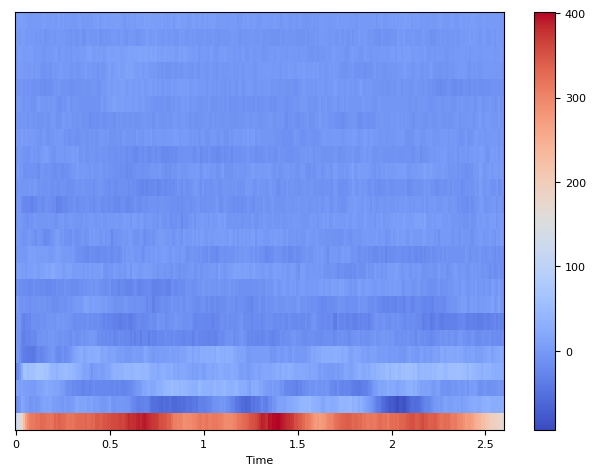

In [7]:
# -- SHOWING THE EFFECTS OF THE PREPROCESSING --

# showing the new lengths
audios_lenghts_trimmed = np.array([audio.size/sample_rate for audio in trimmed_audios]) # audio lengths in seconds
print("#----------------- RECORDINGS LENGTHS DISTRIBUTION AFTER TRIMMING -----------------#")
print(pd.Series(audios_lenghts_trimmed).describe(percentiles=[0.99]))

example = emphasized_audios[idx] # preprocessed random audio sample

# time domain wave plot
print("\n#--------------- EFFECT OF THE PRE PROCESSING ON THE SAMPLE RECORDING ---------------#")
fig, ax = plt.subplots(figsize=(6,2))
ax.plot(np.arange(0, example.size/sample_rate, 1/sample_rate), example, linewidth=0.5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.grid(True)
fig.tight_layout()
plt.show()

# mfcc plot
print("\n#--------------- CEPSTRUM OF THE SAMPLE RECORDING ---------------#")
example_mfccs = mfcc(y=example, sr=sample_rate, n_mfcc=25, n_fft=375, n_mels=40, hop_length=175)
specshow(example_mfccs, x_axis='time', sr=sample_rate, n_fft=375, hop_length=175)
plt.colorbar()
plt.tight_layout()
plt.show

Given a specific speakerId, the values of the other categorical features are fixed; this means that keeping it would most likely provide redundant information that could affect the performances of the model. Moreover, this attribute would be useless for the classification of recordings produced by speakers which are not among the ones of the training set. Hence, we have decided to remove this feature from the final dataset.

In [8]:
# -- CATEGORICAL FEATURES ENCODING --
categorical_features = ['First Language spoken', 'Current language used for work/school', 'gender']
ordinal_features = ['Self-reported fluency level ', 'ageRange']

ordinal_categories = [['basic', 'intermediate', 'advanced', 'native'], ['22-40', '41-65', '65+']]

enc_ord = OrdinalEncoder(categories = ordinal_categories)
enc_cat = OneHotEncoder(sparse=False)

X_ord = enc_ord.fit_transform(df[ordinal_features])
X_cat = enc_cat.fit_transform(df[categorical_features])

# -- FINAL DATASET PREPARATION --
X = np.hstack((zscore(X_audio, 1), X_ord, X_cat))
print(f"Dataset shape: {X.shape}")

Dataset shape: (9854, 5963)


The final dataset is characterized by way too many features, and the classifier could suffer from the curse of dimensionality; in order to solve this problem, we have decided to apply a dimensionality reduction strategy through the PCA.

In [9]:
y = df["label"].values

# -- DIMENSIONALITY REDUCTION --
pca = PCA(n_components=.90, random_state=seed) # we are keeping the 90% of the variance of the original dataset
X_pca = pca.fit_transform(X)

print(f"Dataset shape: {X_pca.shape}")

Dataset shape: (9854, 129)


### 3. Model preparation

In [10]:
# -- MODEL SELECTION --
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=seed)

# candidates
rfc = RandomForestClassifier(random_state=seed)
knc = KNeighborsClassifier()
svc = SVC()

# model fitting
rfc.fit(X_train, y_train)
knc.fit(X_train, y_train)
svc.fit(X_train, y_train)

# evaluation
y_pred_rfc = rfc.predict(X_test)
y_pred_knc = knc.predict(X_test)
y_pred_svc = svc.predict(X_test)

print("RESULTS:")
print(f" - Random forest classifier accuracy: {accuracy_score(y_test, y_pred_rfc)}")
print(f" - KNN accuracy: {accuracy_score(y_test, y_pred_knc)}")
print(f" - SVC accuracy: {accuracy_score(y_test, y_pred_svc)}")

RESULTS:
 - Random forest classifier accuracy: 0.6519533231861999
 - KNN accuracy: 0.7813292744799594
 - SVC accuracy: 0.8290208016235413


In [11]:
# -- VOTING CLASSIFIER --
vc = VotingClassifier(estimators=[
    ('knc', KNeighborsClassifier()),
    ('svc', SVC(probability=True, random_state=seed))
], n_jobs=-1, voting='soft')

vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)

print(f"Voting classifier accuracy: {accuracy_score(y_test, y_pred)}")

Voting classifier accuracy: 0.8427194317605277


The voting classifier based on the KNN and on the SVC is the the model which obtains the highest accuracy score, and therefore we choose it as the classifier for our pipeline. We now need to tune the iperparameters of its modules (KNN and SVC) in order to get the best result possible.

In [12]:
# -- HYPERPARAMETERS TUNING --

# svc
param_grid_svc = {
   "kernel": ["rbf", "poly"],
   "degree": [2, 3],
   "C": [1,5,10,100,500]
}
grv_svc = GridSearchCV(SVC(probability=True, random_state=seed), param_grid=param_grid_svc, scoring="accuracy")
grv_svc.fit(X_pca, y)

# knn
param_grid_knn = {
   "n_neighbors": [5,6,7,8,9,10],
   "metric": ["cosine", "euclidean"],
   "weights": ["distance", "uniform"]
}
grv_knn = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid=param_grid_knn, scoring="accuracy")
grv_knn.fit(X_pca, y)

# results
print(f"SVC best parameters: {grv_svc.best_params_}")
print(f"SVC best accuracy score: {grv_svc.best_score_}")

print(f"\nKNN best parameters: {grv_knn.best_params_}")
print(f"KNN best accuracy score: {grv_knn.best_score_}")

SVC best parameters: {'C': 5, 'degree': 2, 'kernel': 'rbf'}
SVC best accuracy score: 0.8148868749146894

KNN best parameters: {'metric': 'cosine', 'n_neighbors': 6, 'weights': 'distance'}
KNN best accuracy score: 0.8046386307035774


In [13]:
# -- MODEL PREPARATION --

# preparing the two base classifiers
knc = KNeighborsClassifier(metric='cosine', n_neighbors=6, weights='distance', n_jobs=-1)
svc = SVC(kernel='rbf', C=5, probability=True, random_state=seed)

# combining them through the voting classifier
clf = VotingClassifier(estimators=[('knc', knc), ('svc', svc)], n_jobs=-1, voting='soft')
scores = cross_validate(clf, X_pca, y, cv=5, scoring='accuracy')['test_score']

print(f"Scores on the 5 folds: {scores}")
print(f"Mean value: {np.mean(scores)}")

Scores on the 5 folds: [0.84525622 0.84677829 0.8442415  0.90157281 0.74416244]
Mean value: 0.8364022488520089


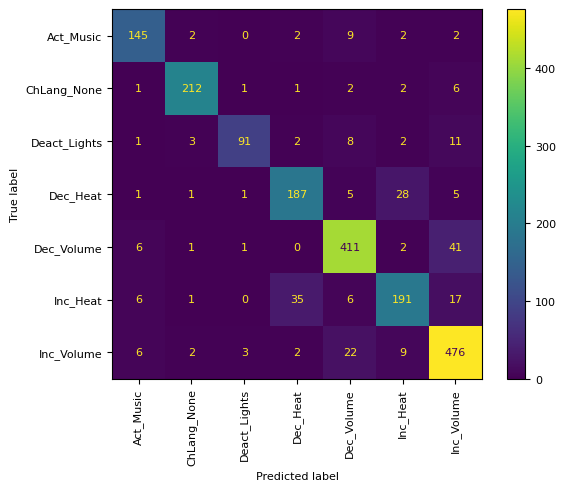

In [14]:
clf.fit(X_train, y_train)
cm = confusion_matrix(y_test, clf.predict(X_test))
disp = ConfusionMatrixDisplay(cm, display_labels=["Act_Music", "ChLang_None", "Deact_Lights", "Dec_Heat", "Dec_Volume", "Inc_Heat", "Inc_Volume"])
disp.plot()
plt.xticks(rotation=90)
plt.show()

### 4. Computation of the prediction

In [15]:
# -- LOADING THE EVALUATION SET --
df_eval = pd.read_csv("./dsl_data/evaluation.csv")
audios_eval = []
for path in df_eval["path"]:
    sr, audio = read(path)
    audio = audio.astype('float32')
    if sr != sample_rate:
        audio = resample(audio, orig_sr=sr, target_sr=sample_rate)
    audios_eval.append(audio)
df_eval['audio'] = audios_eval

# -- AUDIO FEATURES EXTRACTION --
X_audio_eval, _, _, _ = extract_features_from_audio(df_eval['audio'], length)

# -- CATEGORICAL FEATURES ENCODING --
X_eval_ord = enc_ord.transform(df_eval[ordinal_features])
X_eval_cat = enc_cat.transform(df_eval[categorical_features])

# -- COMBINING ALL THE FEATURES --
X_eval = np.hstack((zscore(X_audio_eval, 1), X_eval_ord, X_eval_cat))

# -- PCA --
X_pca_eval = pca.transform(X_eval)

# -- PREDICTION --
clf.fit(X_pca, y) # refitting the model using the entire dataset
y_pred = clf.predict(X_pca_eval)

ev = {i: pred for i, pred in enumerate(y_pred)}
evalsub = pd.DataFrame(columns=["Id", "Predicted"], data=ev.items())
evalsub.to_csv("final.csv", columns=["Id", "Predicted"], index=False) # saving the prediction to a csv

print("Done")

Done
